In [12]:
#pip install diffusers transformers
!pip show diffusers transformers pillow accelerate

Name: diffusers
Version: 0.36.0
Summary: State-of-the-art diffusion in PyTorch and JAX.
Home-page: https://github.com/huggingface/diffusers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/diffusers/graphs/contributors)
Author-email: diffusers@huggingface.co
License: Apache 2.0 License
Location: d:\anaconda3\envs\yolov8\lib\site-packages
Requires: filelock, httpx, huggingface-hub, importlib_metadata, numpy, Pillow, regex, requests, safetensors
Required-by: 
---
Name: transformers
Version: 4.46.3
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: d:\anaconda3\envs\yolov8\lib\site-packages
Requires: filelock, huggi

# 学习AI生图

In [1]:
# 关键：让matplotlib图嵌入notebook显示
%matplotlib inline
import torch
import os
import matplotlib.pyplot as plt
from PIL import Image   #（这个就是pillow）
import accelerate
from diffusers import StableDiffusionPipeline

## 先跑一个demo  

该模型**5.1G**,运行需要**4G显存**  
导入必备的包

保证设备是GPU（CUDA）

In [6]:
#这一定要保证输出的是cuda
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

下载模型到当前目录  
下载完看一下本地目录文件位置对不对，我的在./sd-v1-5/models--sd-legacy--stable-diffusion-v1-5/snapshots/451f4fe16113bff5a5d2269ed5ad43b0592里，请把里面所有文件剪切到./sd-v1-5

In [20]:
# 1. 定义下载目录（代码同目录的 sd-v1-5-download 文件夹）
# 相对路径（推荐）：./ 表示当前代码所在目录
download_dir = "./sd-v1-5"

# 2. 确保目录存在（如果不存在则自动创建）
os.makedirs(download_dir, exist_ok=True)

# 3. 加载模型时指定下载目录（核心：cache_dir 参数）
model_id = "sd-legacy/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    cache_dir=download_dir,  # 指定模型下载到当前目录
).to("cuda")

#清除显存占用
del pipe
torch.cuda.empty_cache()
import gc
gc.collect()

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

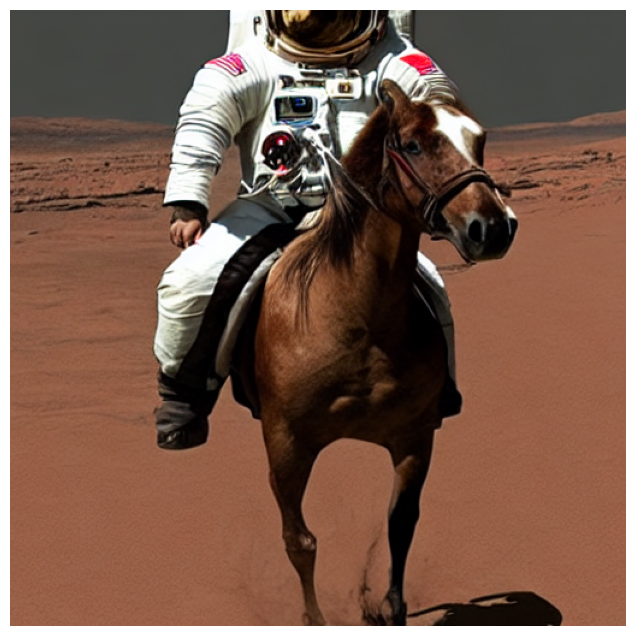

2155

In [31]:
# 加载模型
model_path = "./sd-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16
)
pipe = pipe.to("cuda")

#优化效果（4G显存要用用）
from diffusers import EulerDiscreteScheduler
pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)

prompt = "a photo of an astronaut riding a horse on mars"
image = pipe(prompt).images[0]

plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis("off")
plt.show()

#清除显存占用
del pipe
torch.cuda.empty_cache()
import gc
gc.collect()

## 学习StableDiffusion 的使用

### 文生图 和 学习参数

prompt	               正向提示词：告诉 SD 要生成什么   
negative_prompt	       反向提示词：告诉 SD 不要生成什么   	   
num_inference_steps	   采样步数：反向扩散的迭代次数（UNet 去噪的次数）   	
guidance_scale (CFG)   文本引导尺度：控制图像贴合提示词的程度	   
height/width	       生成图像的尺寸（必须是 64 的倍数，SD 默认 512x512）   
generator	           随机数生成器：固定种子可复现相同图像   
batch_size             批量大小，一次生成的图片数量

标签超市：https://tags.novelai.dev/   
github：https://github.com/wfjsw/danbooru-diffusion-prompt-builder  

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

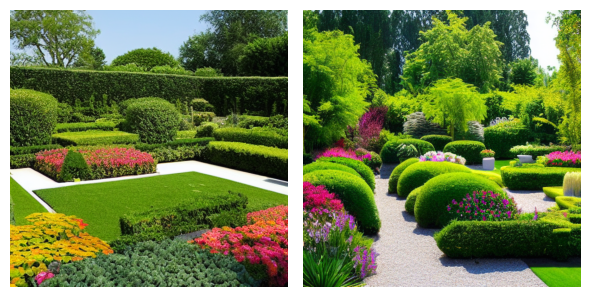

43

In [17]:
pipe = StableDiffusionPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    safety_checker=None,              # 关闭安全检查器实例（支持NSFW）
    requires_safety_checker=False,    # 禁用安全检查器依赖
).to("cuda")

#优化效果（4G显存要用用）
from diffusers import EulerDiscreteScheduler
pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)

#正向提示词
prompt = "garden, masterpiece, best quality"
#反向提示词
negative_prompt = "bad anatomy, missing arms, bad hands, ponytail, lowres, text, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry"
num_inference_steps = 50
guidance_scale = 7.5
num_images_per_prompt = 2
generator = torch.Generator("cuda").manual_seed(42)  # 固定种子

images = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    num_images_per_prompt=num_images_per_prompt,
    generator=generator  # 固定种子
).images

#画图可视化（2张图按2行1列展示）
fig, axes = plt.subplots(1, 2, figsize=(6, 6))  # 2行2列，画布大小12x12
axes = axes.flatten()                             # 把2x2的坐标轴转成一维列表，方便循环

# 循环显示每张图
for idx, img in enumerate(images):
    axes[idx].imshow(img)  # 显示图片
    axes[idx].axis("off")  # 隐藏坐标轴，更美观

# 调整子图间距，避免重叠
plt.tight_layout()
plt.show()


#清除显存占用
del pipe
torch.cuda.empty_cache()
import gc
gc.collect()

### 图生图

In [5]:
from diffusers import StableDiffusionImg2ImgPipeline

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

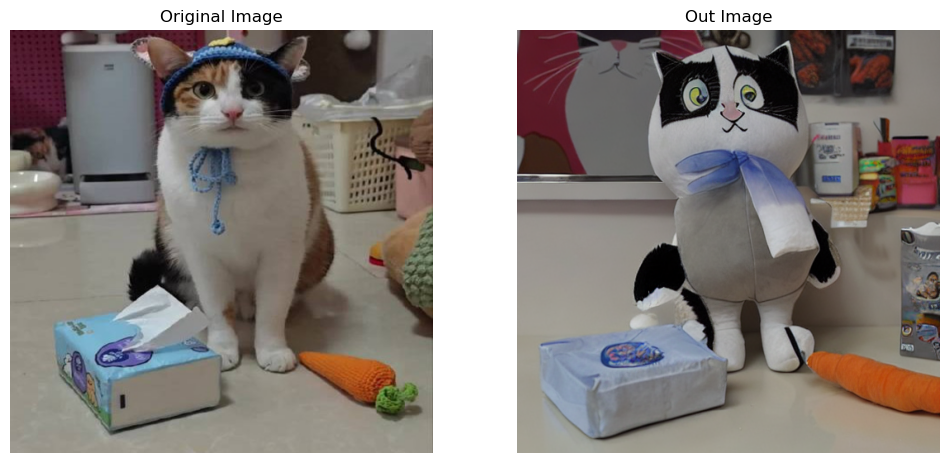

5190

In [16]:
model_path = "./sd-v1-5"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True,
    safety_checker=None,
    requires_safety_checker=False
).to("cuda")

# 2. 加载参考图（替换为你的图片路径）
init_image = Image.open("./data/StableDiffusion/carrot_paper_cat.jpg").resize((512, 512))

# 3. 定义提示词（目标风格）
prompt = "in the middle is a cat, in the lower left corner is a pack of tissues, and in the lower right corner is a plush carrot toy, cartoon style, masterpiece, best quality"
negative_prompt = "lowres, text, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry"

# 4. 图生图（strength=0.6 控制重绘强度，0-1）
image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image=init_image,
    strength=0.6,  # 0.2=轻微修改，0.8=大幅重绘
    num_inference_steps=50,
    guidance_scale=7.5
).images[0]

# 5. 对比显示原图和生成图
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.imshow(init_image)
ax1.set_title("Original Image")
ax1.axis("off")

ax2.imshow(image)
ax2.set_title("Out Image")
ax2.axis("off")

plt.show()

#清除显存占用
del pipe
torch.cuda.empty_cache()
import gc
gc.collect()

### Waifu Diffusion (动漫图片:文生图)

下载完记得手动移一下模型位置  
该模型**6G**左右，运行需要**3G显存**

In [18]:
download_dir = "./waifu-sd-v1-4"
os.makedirs(download_dir, exist_ok=True)

model_id = 'hakurei/waifu-diffusion'
pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    cache_dir=download_dir,  # 指定模型下载到当前目录
)

#清除显存占用
del pipe
torch.cuda.empty_cache()
import gc
gc.collect()

model_index.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

D:\anaconda3\envs\yolov8\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Dr.Weiss\深度学习d2l\pytorch_study\waifu-sd-v1-4\models--hakurei--waifu-diffusion. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


preprocessor_config.json:   0%|          | 0.00/518 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/620 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/819 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json: 0.00B [00:00, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


vocab.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/601 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

29

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

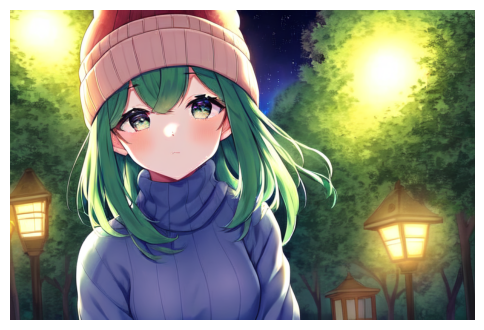

2157

In [29]:
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler

model_path = './waifu-sd-v1-4'
pipe = StableDiffusionPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
    safety_checker=None,        # 关闭安全检查器，节省显存
    requires_safety_checker=False
).to("cuda")

# 切换高效采样器（减少步数+速度）
pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)

# 生图参数
prompt = "masterpiece, best quality, 1girl, green hair, sweater, looking at viewer, upper body, beanie, outdoors, watercolor, night, turtleneck"
negative_prompt = "lowres, text, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry"

# 关键参数：分辨率/步数/批量数（6G显存极限配置）
image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=50,  
    guidance_scale=7.5,       
    width=768,              
    height=512,
    num_images_per_prompt=1, # 必须设为1，批量生成必OOM
).images[0]

# 6. 显示图片
plt.figure(figsize=(6,6))
plt.imshow(image)
plt.axis("off")
plt.show()

#清除显存占用
del pipe
torch.cuda.empty_cache()
import gc
gc.collect()

### lightx2v框架（需要python>=3.10）暂时跳过

In [41]:
import sys
print("Python版本：", sys.version)

Python版本： 3.8.19 (default, Mar 20 2024, 19:55:45) [MSC v.1916 64 bit (AMD64)]


不能够用pip install lightx2v安装

In [31]:
!git clone https://github.com/ModelTC/LightX2V.git

Cloning into 'LightX2V'...


In [40]:
pip install -v ./LightX2V

In [ ]:
from lightx2v import optimize_pipeline  # 导入 LightX2V 优化函数

# 1. 加载 SD 模型（沿用你熟悉的代码，仅添加优化步骤）
model_path = "./sd-v1-5"  # 你的本地 SD 模型路径
pipe = StableDiffusionPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16,  # 基础精度优化
    safety_checker=None,
    requires_safety_checker=False
).to("cuda")

# 2. 核心：用 LightX2V 优化 SD 管道（关键优化步骤）
pipe = optimize_pipeline(
    pipeline=pipe,
    precision="fp8",         # 量化精度：fp8/int8，显存紧张选 int8
    offload_level="auto",    # 内存卸载：auto/cpu/disk，自动调度 GPU-CPU 内存
    enable_light_vae=True,   # 启用轻量 VAE，显存降低 50%
    distill_steps=8          # 推理步数蒸馏：从 50 步压缩到 8 步，速度提升 6 倍
)

# 3. 生图参数（保持你熟悉的配置）
prompt = "a cute orange cat sitting on a wooden chair, masterpiece, best quality"
negative_prompt = "lowres, blurry, ugly, distorted"
num_inference_steps = 8      # 必须与 distill_steps 一致（LightX2V 蒸馏后固定）
guidance_scale = 7.5
num_images_per_prompt = 2    # 批量生成（低显存建议 1-2 张）

# 4. 执行生图（验证优化效果）
res = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    num_images_per_prompt=num_images_per_prompt,
    generator=torch.Generator("cuda").manual_seed(42)
)

# 5. ipynb 可视化显示
images = res.images
fig, axes = plt.subplots(1, len(images), figsize=(12, 6))

for idx, img in enumerate(images):
    axes[idx].imshow(img)
    axes[idx].axis("off")
    axes[idx].set_title(f"Image {idx+1} (LightX2V 优化)")
    
plt.tight_layout()
plt.show()

### Z-Image（需要最最新的transformers）

建议手动下，下载完记得手动移一下模型位置  
该模型需要**？G显存**

In [43]:
from diffusers import ZImagePipeline

In [7]:
download_dir = "./z-image-sd2"
os.makedirs(download_dir, exist_ok=True)

model_id = 'Tongyi-MAI/Z-Image-Turbo'
pipe = ZImagePipeline.from_pretrained(
    model_id,
    # torch_dtype=torch.bfloat16,   # 3090、40、50系显卡用这个
    torch_dtype=torch.float16,      # 30系及以下用这个
    cache_dir=download_dir,  # 指定模型下载到当前目录
)

#清除显存占用
del pipe
torch.cuda.empty_cache()
import gc
gc.collect()

In [9]:
from diffusers import ZImagePipeline

model_path = "./z-image-sd"
pipe = ZImagePipeline.from_pretrained(
    model_path,
    torch_dtype=torch.bfloat16,
    # low_cpu_mem_usage=False,
    # variant="fp8",  # 使用FP8量化优化（可选）
).to("cuda")

#清除显存占用
del pipe
torch.cuda.empty_cache()
import gc
gc.collect()

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

AttributeError: module transformers has no attribute Qwen3Model

In [16]:
!pip uninstall transformers -y

Found existing installation: transformers 4.46.3
Uninstalling transformers-4.46.3:
  Successfully uninstalled transformers-4.46.3


In [18]:
pip install transformers==4.57.0

Looking in indexes: https://mirrors.ustc.edu.cn/pypi/web/simple
Could not fetch URL https://mirrors.ustc.edu.cn/pypi/web/simple/transformers/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='mirrors.ustc.edu.cn', port=443): Max retries exceeded with url: /pypi/web/simple/transformers/ (Caused by SSLError(SSLZeroReturnError(6, 'TLS/SSL connection has been closed (EOF) (_ssl.c:1135)'))) - skipping
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement transformers==4.57.0 (from versions: none)
ERROR: No matching distribution found for transformers==4.57.0


In [15]:
from transformers import Qwen3Model

ImportError: cannot import name 'Qwen3Model' from 'transformers' (D:\anaconda3\envs\yolov8\lib\site-packages\transformers\__init__.py)

## 学习使用ControlNet 可控生图 的使用

## 学习LoRA微调

## StableDiffusion的详细实现

## 学习使用ComfyUI（可能写不到这上面来）